## Imports

In [1]:
import torch
import torch.nn as nn
import scipy.stats as stats
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchviz import make_dot
from torch import optim
import matplotlib.pyplot as plt



from icnnet import ICNNet
from mydataset import MyDataset
import toy_data_dataloader_gaussian

In [2]:
%load_ext autoreload
%autoreload 2

## Toy data


In [3]:
dataloader, locs, scales = toy_data_dataloader_gaussian.get_dataloader(N = 5000, batch_size = 100, r = 200)

## Training

### PICNN training

In [4]:
epochs = 25

# Initialize the model
model = ICNNet(input_size=2, layer_sizes = [2,4,2], context_layer_sizes=[2,2,2])
model.train()

# Define the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

for epoch in range(epochs):
    for x_batch, c_batch, y_batch in dataloader:
        x_batch.requires_grad_(True)
        c_batch.requires_grad_(True)

        optimizer.zero_grad() # Zero the gradients
        
        output = model(x_batch, c_batch)  # Assuming context c is same as input x

        loss = criterion(output, y_batch) # Compute the loss
        loss.backward() # Backward pass

        optimizer.step() # Update the parameters
        for layers_k in model.layers_z:
            for param in layers_k.parameters():
                param.data.clamp_min_(0)
        
        #pass

    #for name, parameter in model.named_parameters():
        #if parameter.requires_grad and parameter.grad is not None:
            #grad_norm = parameter.grad.norm().item()
            #print(f"Gradient norm for {name}: {grad_norm}")

    print(f"Epoch {epoch+1}/{epochs} Loss: {loss.item()}")




Epoch 1/25 Loss: 52.047733306884766
Epoch 2/25 Loss: 40.386478424072266
Epoch 3/25 Loss: 40.3858757019043
Epoch 4/25 Loss: 36.15321731567383
Epoch 5/25 Loss: 35.712615966796875
Epoch 6/25 Loss: 32.09666061401367
Epoch 7/25 Loss: 25.156095504760742
Epoch 8/25 Loss: 24.87603187561035
Epoch 9/25 Loss: 23.960582733154297
Epoch 10/25 Loss: 20.138912200927734
Epoch 11/25 Loss: 16.928974151611328
Epoch 12/25 Loss: 14.341309547424316
Epoch 13/25 Loss: 11.929084777832031
Epoch 14/25 Loss: 12.088238716125488
Epoch 15/25 Loss: 10.745984077453613
Epoch 16/25 Loss: 11.005712509155273
Epoch 17/25 Loss: 9.36450481414795
Epoch 18/25 Loss: 10.33370304107666
Epoch 19/25 Loss: 8.737859725952148
Epoch 20/25 Loss: 9.2402982711792
Epoch 21/25 Loss: 9.480072021484375
Epoch 22/25 Loss: 9.391923904418945
Epoch 23/25 Loss: 9.30866527557373
Epoch 24/25 Loss: 9.253122329711914
Epoch 25/25 Loss: 7.478682994842529


In [5]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Suppose 'model' is your PyTorch model
num_parameters = count_parameters(model)

print(f'The model has {num_parameters} parameters')

The model has 88 parameters


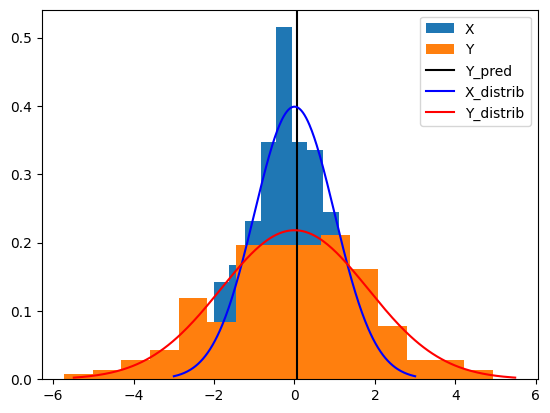

In [7]:
X = dataloader.dataset.X
Y = dataloader.dataset.Y
C = dataloader.dataset.C


Y_pred  = model(X, C)[0, :, 0].detach().numpy().mean()

plt.hist(X[0, :, 0],  bins=15, label = 'X', density = True)
plt.hist(Y[0, :, 0],  bins=15, label = 'Y', density = True)
plt.axvline(x = Y_pred, color = 'black', label = 'Y_pred')
plt.plot(np.linspace(-3, 3, 300), stats.norm.pdf(np.linspace(-3, 3, 300), loc=0, scale=1), label = 'X_distrib', color = 'blue')
plt.plot(np.linspace(-3*scales[0, 0] + locs[0, 0], 3*scales[0, 0] + locs[0, 0], 300), stats.norm.pdf(np.linspace(-3*scales[0, 0] + locs[0, 0], 3*scales[0, 0] + locs[0, 0], 300), loc=locs[0, 0], scale=scales[0, 0]), label = 'Y_distrib', color = 'red')

plt.legend()

plt.show()
         





In [12]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for x_batch, c_batch, y_batch in dataloader:
        outputs = model(x_batch, c_batch)
        for result, y in zip(outputs, y_batch) :
            print(result, y)
        break



tensor([0.9659]) tensor([0.9711])
tensor([-0.8608]) tensor([-0.8804])
tensor([-1.5514]) tensor([-1.5494])
tensor([-2.0634]) tensor([-2.0654])
tensor([-0.3589]) tensor([-0.3625])
tensor([-0.0569]) tensor([-0.0557])
tensor([0.2998]) tensor([0.3047])
tensor([0.5297]) tensor([0.5354])
tensor([-0.1235]) tensor([-0.1228])
tensor([0.9448]) tensor([0.9500])
tensor([1.9734]) tensor([1.9713])
tensor([-0.3519]) tensor([-0.3491])
tensor([1.6254]) tensor([1.6264])
tensor([2.1131]) tensor([2.1097])
tensor([1.3164]) tensor([1.3198])
tensor([2.5679]) tensor([2.5597])
tensor([0.2010]) tensor([0.2053])
tensor([1.0198]) tensor([1.0247])
tensor([0.7091]) tensor([0.7148])
tensor([-0.9824]) tensor([-0.9785])
tensor([1.9971]) tensor([1.9948])
tensor([0.9218]) tensor([0.9271])
tensor([0.4286]) tensor([0.4341])
tensor([2.5955]) tensor([2.5870])
tensor([1.0804]) tensor([1.0850])
tensor([-0.4405]) tensor([-0.4374])
tensor([0.6309]) tensor([0.6259])
tensor([-1.2735]) tensor([-1.2702])
tensor([-1.1432]) tensor([-1

### Makkuva

In [8]:
epochs = 100
train_freq_g = 20

# Initialize the model
input_size = 2
ICNNf = ICNNet(input_size = 2, layer_sizes = [input_size, 2,2,2,2,2], context_layer_sizes=[2,2,2,2,2,2])

output_size = 2

ICNNg = ICNNet(input_size = 2, layer_sizes = [output_size, 2,2,2,2,2], context_layer_sizes=[2,2,2,2,2,2])

# Define the loss function and the optimizer
optimizer_f = optim.Adam(ICNNf.parameters())
optimizer_g = optim.Adam(ICNNg.parameters())

for epoch in range(epochs):
    for _ in range(train_freq_g) :
        for x, c, y in dataloader:
            # Optimizing ICNNg
            optimizer_f.zero_grad() # Zero the gradients
            optimizer_g.zero_grad() # Zero the gradients

            x.requires_grad_(True)
            y.requires_grad_(True)
            c.requires_grad_(True)

            output_g = ICNNg(y, c)
            
            print(torch.mean(output_g, axis = 0).size())
            print(output_g.size())

            grad_g = torch.autograd.grad(output_g, y, grad_outputs=torch.ones_like(output_g), create_graph=True)[0]

            print(grad_g.size())
            
            loss_g = -ICNNf(grad_g, c) #- torch.matmul(y.transpose(0, 1), diff_output_g)
            print("loss : ", torch.mean(loss_g, axis= 0).size())
            loss_g = torch.mean(loss_g)
            loss_g.backward() # Backward pass

            optimizer_g.step() # Update the parameters
            for layers_k in ICNNg.layers_z:
                for param in layers_k.parameters():
                    param.data.clamp_min_(0)

    for x, c, y in dataloader:
        optimizer_f.zero_grad() # Zero the gradients
        optimizer_g.zero_grad()
        x.requires_grad_(True)
        y.requires_grad_(True)
        c.requires_grad_(True)
        


        output_g = ICNNg(y, c)
        diff_output_g = torch.autograd.grad(outputs=output_g, inputs=y, grad_outputs=torch.ones_like(output_g), create_graph=True)[0]

        loss_f = ICNNf(x, c) - ICNNf(diff_output_g, c)
        loss_f = torch.mean(loss_f)

        loss_f.backward() # Backward pass
        
        for layers_k in ICNNf.layers_z:
                for param in layers_k.parameters():
                    param.data.clamp_min_(0)


        #testing algorithm
        output_g_test = ICNNg(x, c)
        diff_output_g_test = torch.autograd.grad(output_g_test, x, grad_outputs=torch.ones_like(output_g_test), create_graph=True)[0]

        loss_test = diff_output_g_test-y

        #print('y =', y[0], 'diff_output_g =', diff_output_g_test[0])
        
        pass

    print(f"Epoch {epoch+1}/{epochs} loss_g: {loss_g.item()}, loss_f: {loss_f.item()}")

torch.Size([200, 2])
torch.Size([100, 200, 2])
torch.Size([100, 200, 2])
loss :  torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([100, 200, 2])
torch.Size([100, 200, 2])
loss :  torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([100, 200, 2])
torch.Size([100, 200, 2])
loss :  torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([100, 200, 2])
torch.Size([100, 200, 2])
loss :  torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([100, 200, 2])
torch.Size([100, 200, 2])
loss :  torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([100, 200, 2])
torch.Size([100, 200, 2])
loss :  torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([100, 200, 2])
torch.Size([100, 200, 2])
loss :  torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([100, 200, 2])
torch.Size([100, 200, 2])
loss :  torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([100, 200, 2])
torch.Size([100, 200, 2])
loss :  torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([100, 200, 2])
torch.Size([100, 200, 2])
loss :  t

KeyboardInterrupt: 